# Learning a model

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

Do you remember the Predictwise probabilities question from two labs back? We learnt how to simulate from the predictwise probabilities.

##The process of learning

But how did we get those probabilities in the first place? To do that, we need to focus on **learning a model** for those probabilities.

Here we encounter some challenges that occur in learning such a model from data. These challenges are small samples of data and noise in the data, as well as issues related to the complexity of the models we use, such as bias, and variance or overfitting. We'll encounter hypothesis spaces, and the basic idea of error or risk minimization that is used to learn models. We'll also see the critcal and multifarious role that sampling plays in the learning process.

Lets say we are trying to predict is a human process such as an election. Here economic and sociological factors are important, such as poverty, race and religiousness. There are historical correlations between such factors and election outcomes which we might want to incorporate into our model. An example of such a model might be:

*The odds of Romney winning are a function of population religiosity, race, poverty, education, and other social and economic indicators. *

Our **causal** argument motivating this model here might be that religious people are more socially conservative and thus more likely to vote republican. This might not be the correct causation, but thats not entirely important for the prediction. As long as a **correlation** exists, our model is more structured than 50-50 randomness, and we can try and make a prediction. Remember of-course, our model may even be wrong (see Box's aphorism: https://en.wikipedia.org/wiki/All_models_are_wrong).

We'll represent the variable being predicted, such as the probability of voting for Romney, by the letter $y$, and the **features** or **co-variates** we use as an input in this probability by the letter $x$. This $x$ could be multi-dimensional, with $x_1$ being poverty, $x_2$ being race, and so on.

We then write 

$$ y = f(x) $$

and our jobs is to take $x$ such as data from the census about race, religiousness, and so on, and $y$ as previous elections and the results of polls that pollsters come up with, and to make a predictive model for the elections. That is, we wish to estimate $f(x)$.

The more domain knowledge we can bring to bear on this problem, the better. The work of folks like Nate Silver isnt just the statistical analysis. They combine their statistical expertise with modelling choices about causal and correlational effects based on their domain knowledge. Sometimes they are right and sometimes wrong.

### A real simple model

To gently step feet in the modelling world, lets see consider very simple model, where the probability of voting for Romney is a function only of how religious the population in a county is.

Let $x$ be the fraction of religious people in a county and $y$ be the probability of voting for Romney as a function of $x$. In other words $y_i$ is data that pollsters have taken which tells us their estimate of people voting for Romney and $x_i$ is the fraction of religious people in county $i$. Because poll samples are finite, there is a margin of error on each data point or county $i$, but we will ignore that for now.

Let us assume that we have a "population" of 200 counties $x$:

In [3]:
df=pd.read_csv("religion.csv")
df.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


Lets suppose now that the Lord came by and told us that the points in the plot below captures $f(x)$ exactly. 

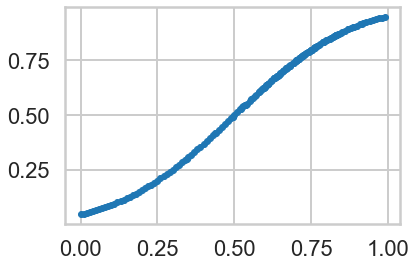

In [4]:
x=df.rfrac.values
f=df.promney.values
plt.plot(x,f,'.')

Notice that our sampling of $x$ is not quite uniform: there are more points around $x$ of 0.7.

Now, in real life we are only given a sample of points. Lets assume that out of this population of 200 points we are given a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, the entire population of data points is also called **out-of-sample data**.

In [5]:
#allindexes=np.sort(np.random.choice(x.shape[0], size=100, replace=False))
indexes=np.sort(np.random.choice(x.shape[0], size=30, replace=False))

In [6]:
samplex = x[indexes]
samplef = f[indexes]

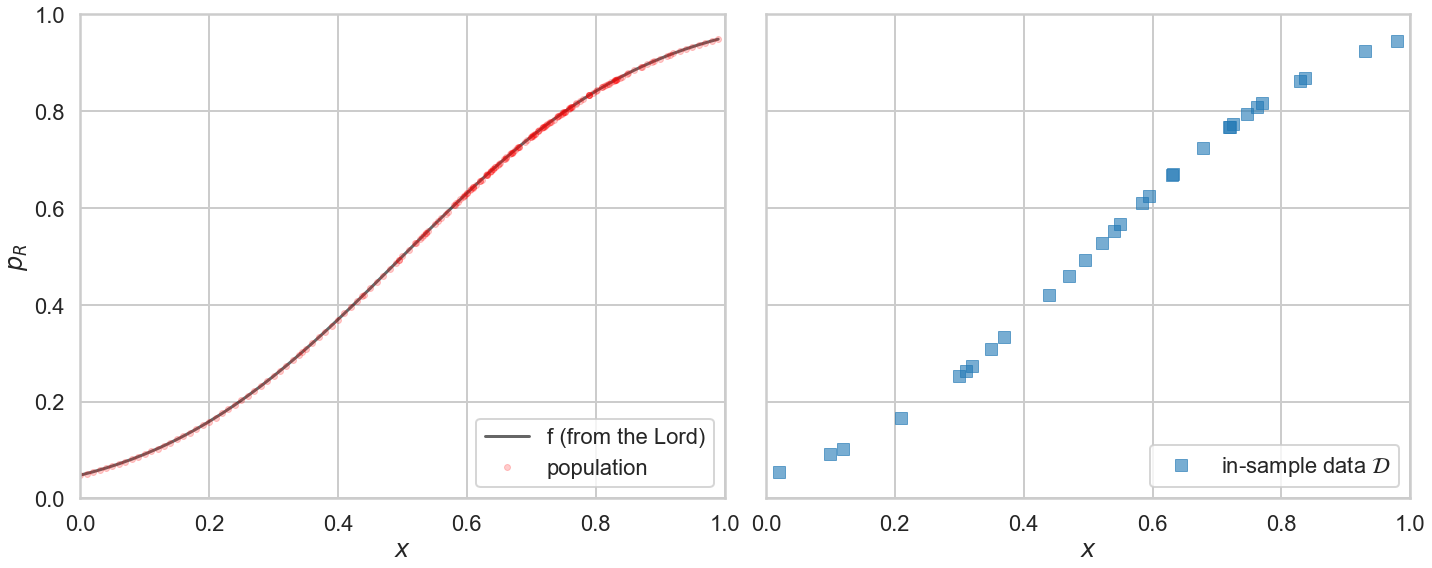

In [7]:
axes=make_plot()
axes[0].plot(x,f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[0].plot(x,f, 'r.', alpha=0.2, label="population");
axes[1].plot(samplex,samplef, 's', alpha=0.6, label="in-sample data $\cal{D}$");
axes[0].legend(loc=4);
axes[1].legend(loc=4);

The lightly shaded squares in the right panel plot are the in-sample $\cal{D}$ of 30 points given to us. Let us then pretend that we have forgotten the curve that the Lord gave us. Thus, all we know is what is on the plot on the right, and we have no clue about what the original curve was, nor do we remember the original "population".

That is, imagine the Lord gave us $f$ but then also gave us amnesia. Remember that such amnesia is the general case in learning, where we *do not know* the target function, but rather just have some data. Thus what we will be doing is *trying to find functions that might have generated the 30 points of data that we can see* in the hope that one of these functions might approximate $f$ well, and provide us a **predictive model** for future data. This is known as **fitting** the data.

###The Hypothesis or Model Space

Such a function, one that we use to fit the data, is called a **hypothesis**. We'll use the notation $h$ to denote a hypothesis. Lets consider as hypotheses for the data above, a particular class of functions called polynomials. 

A polynomial is a function that combines multiple powers of x linearly.  You've probably seen these in school, when working with quadratic or cubic equations and functions:

\begin{align*}
h(x) &=& 9x - 7 && \,(straight\, line) \\
h(x) &=& 4x^2 + 3x + 2 && \,(quadratic) \\
h(x) &=& 5x^3 - 31x^2 + 3x  && \,(cubic).
\end{align*}

In general, a polynomial can be written thus:

\begin{eqnarray*}
 h(x) &=& a_0 + a_1 x^1 + a_2 x^2 + ... + a_n x^n \\
      &=& \sum_{i=0}^{n} a_i x^i
\end{eqnarray*}

Thus, by linearly we mean a sum of coefficients $a_i$ times powers of $x$, $x^i$. In other words, the polynomial is **linear in its coefficients**.

Let us consider as the function we used to fit the data, a hypothesis $h$ that is a straight line. We put the subscript $1$ on the $h$ to indicate that we are fitting the data with a polynomial of order 1, or a straight line. This looks like:

$$ h_1(x) = a_0 + a_1 x $$

We'll call the **best fit** straight line the function $g_1(x)$. The "best fit" idea is this: amongst the set of all lines (i.e., all possible choices of $h_1(x)$), what is the best line $g_1(x)$ that represents the in-sample data we have? (The subscript $1$ on $g$ is chosen to indicate the best fit polynomial of degree 1, ie the line amongst lines that fits the data best).

The best fit $g_1(x)$ is calculated and shown in the figure below:

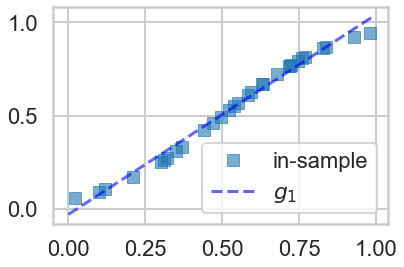

In [8]:
g1 = np.poly1d(np.polyfit(x[indexes],f[indexes],1))
plt.plot(x[indexes],f[indexes], 's', alpha=0.6, label="in-sample");
plt.plot(x,g1(x), 'b--', alpha=0.6, label="$g_1$");
plt.legend(loc=4);

How did we calculate the best fit? We'll come to that in a bit, but in the meanwhile, lets formalize and generalize the notion of "best fit line amongst lines" a bit.

The set of all functions of a particular kind that we could have used to fit the data is called a **Hypothesis Space**. The words "particular kind" are deliberately vague: its our choice as to what we might want to put into a hypothesis space. A hypothesis space is denoted by the notation $\cal{H}$.

Lets consider the hypothesis space of all straight lines $h_1(x)$. We'll denote it as $\cal{H}_1$, with the subscript being used to mark the order of the polynomial. Another such space might be $\cal{H}_2$, the hypothesis space of all quadratic functions. A third such space might combine both of these together. We get to choose what we want to put into our hypothesis space.

In this set-up, what we have done in the code and plot above is this: we have found the best $g_1$ to the data $\cal{D}$ from the functions in the hypothesis space $\cal{H}_1$. This is not the best fit from all possible functions, but rather, the best fit from the set of all the straight lines. 

The hypothesis space is a concept we use to capture the **complexity** of a model you use to fit data. For example, since quadratics are more complex functions than straight lines (they curve more), $\cal{H}_2$ is more complex than $\cal{H}_1$. 

In this case, suffering from amnesia about the real model, we decided to use the simplest hypothesis space that gives us some indication of the *trend* of our data: the set of straight lines.

###Deterministic Error or Bias

Notice from the figure above that models in $\cal{H}_1$, i.e., straight lines, and the best-fit straight line $g_1$ in particular, do not do a very good job of capturing the curve of  the data (and thus the underlying function $f$ that we are trying to approximate. Consider the more general case in the figure below, where a curvy $f$ is approximated by a function $g$ which just does not have the wiggling that $f$ has. 

![m:Bias](./images/bias.png)

There is always going to be an error then, in approximating $f$ by $g$. This *approximation error* is shown in the figure by the blue shaded region, and its called **bias**, or **deterministic error**. The former name comes from the fact that $g$ just does not wiggle the way $f$ does (nothing will make a straight line curve). The latter name (which I first saw used in http://www.amlbook.com/ ) comes from the notion that if you did not know the target function $f$, which is the case in most learning situations, you would have a hard time distinguishing this error from any other errors such as measurement and noise...

Going back to our model at hand, it is clear that the space of straight lines $\cal{H}_1$ does not capture the curving in the data. So let us consider the more complex hypothesis space $\cal{H}_{20}$, the set of all 20th order polynomials $h_{20}(x)$:

$$h_{20}(x) = \sum_{i=0}^{20} a_i x^i\,.$$


To see how a more complex hypothesis space does, lets find the best fit 20th order polynomial $g_{20}(x)$.

In [9]:
g20 = np.poly1d(np.polyfit(x[indexes],f[indexes],20))

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


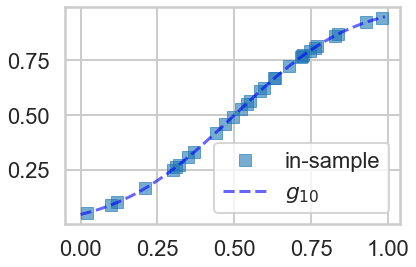

In [10]:
plt.plot(x[indexes],f[indexes], 's', alpha=0.6, label="in-sample");
plt.plot(x,g20(x), 'b--', alpha=0.6, label="$g_{10}$");
plt.legend(loc=4);

Voila! You can see the 20th order polynomial does a much better job of tracking the points, because of the wiggle room it has in making a curve "go near or through" all the points as opposed to a straight line, which well, cant curve. Thus it would seem that $\cal{H}_{10}$ might be a better candidate hypothesis set from which to choose a best fit model. 

We can quantify this by calculating some notion of the bias for both $g_1$ and $g_{20}$. 
To do this we calculate the square of the difference between f and the g's on the population of 200 points i.e.:

$$B_1(x) = (g_1(x) - f(x))^2 \,;\,\, B_{20}(x) = (g_{20}(x) - f(x))^2\,.$$ 

Squaring makes sure that we are calculating a positive quantity.

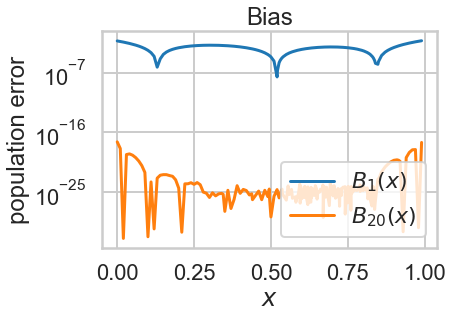

In [11]:
plt.plot(x, (g1(x)-f)**2, lw=3, label="$B_1(x)$")
plt.plot(x, (g20(x)-f)**2, lw=3,label="$B_{20}(x)$");
plt.xlabel("$x$")
plt.ylabel("population error")
plt.yscale("log")
plt.legend(loc=4);
plt.title("Bias");

As you can see the **bias or approximation error** is much smaller for $g_{20}$.

Is $g_{20}$ the best model for this data from all possible models? Indeed, how do we find the best fit model from the best hypothesis space? This is what **learning** is all about.

We have used the python function `np.polyfit` to find $g_{1}$ the best fit model in $\cal{H}_{1}$ and $g_{20}$ the best fit model in $\cal{H}_{20}$, but how did we arrive at that conclusion? This is the subject of the next section. 

###How to learn the best fit model in a hypothesis space

Let's understand in an intuitive sense, what it means for a function to be a good fit to the data. Lets consider, for now, only the hypothesis space $\cal{H}_{1}$, the set of all straight lines. In the figure below, we draw against the data points (in red) one such line $h_1(x)$ (in red).

![m:Cost](./images/linreg.png)

The natural way of thinking about a "best fit" would be to minimize the distance from the line to the points, for some notion of distance. In the diagram we depict one such notion of distance: the vertical distance from the points to the line. These distances are represented as thin black lines.

The next question that then arises is this: how exactly we define the measure of this vertical distance? We cant take the measure of distance to be the y-value of the point minus the y value of the line at the same x, ie $y_i - h_1(x_i)$. Why? If we did this, then we could have points very far from the line, and as long as the total distance above was equal to the total distance below the line, we'd get a net distance of 0 even when the line is very far from the points.

Thus we must use a positive estimate of the distance as our measure. We could take either the absolute value of the distance, $\vert y_i - h_1(x_i) \vert$, or the square of the distance as our measure, $(y_i - h_1(x_i))^2$. Both are reasonable choices, and we shall use the squared distance for now. (Now its probably clear to you why we defined bias in the last section as the pointwise square of the distance).

We sum this measure up over all our data points, to create whats known as the **error functional** or **risk functional** (also just called **error*, **cost**, or **risk**) of using line $h_1(x)$ to fit our points $y_i \in \cal{D}$ (this notation is to be read as "$y_i$ in $\cal{D}$") :

$$ R_{\cal{D}}(h_i(x)) = \frac{1}{N} \sum_{y_i \in \cal{D}} (y_i - h_1(x_i))^2 $$

where $N$ is the number of points in $\cal{D}$.

What this formula says is: the cost or risk is just the total squared distance to the line from the observation points. Here we use the word **functional** to denote that, just as in functional programming, the risk is a *function of the function* $h_1(x)$. 

We also make explicit the in-sample data $\cal{D}$, because the value of the risk depends upon the points at which we made our observation. If we had made these observations $y_i$ at a different set of $x_i$, the value of the risk would be somewhat different. The hope in learning is that the risk will not be too different, as we shall see in the next section

Now, given these observations, and the hypothesis space $\cal{H}_1$, we minimize the risk over all possible functions in the hypothesis space to find the **best fit** function $g_1(x)$:

$$ g_1(x) = \arg\min_{h_1(x) \in \cal{H}} R_{\cal{D}}(h_1(x)).$$

Here the notation 

$"\arg\min_{x} F(x)"$ 

means: give me the argument of the functional $x$ at which $F(x)$ is minmized. So, for us: give me the function $g_1(x) = h_1$ at which the risk $R_{\cal{D}}(h_1)$ is minimized; i.e. the minimization is over *functions* $h_1$.

(We'll wont worry about how to actually do this minimization, since the `sklearn` and `statsmodels` functions actually do this for us, currently we are just interested in the conceptual notions).

And this is exactly what the python function `np.polyfit(x,h,n)` does for us. It minimizes this squared-error with respect to the coefficients of the polynomial.

Thus we can in general write:

$$ g(x) = \arg\min_{h(x) \in \cal{H}} R_{\cal{D}}(h(x)),$$

where $\cal{H}$ is a general hypothesis space of functions.

##The Structure of Learning

We have a target function $f(x)$ that we do not know. But we do have a sample of data points from it, $(x_1,y_1), (x_2,y_2), ..., (x_n,y_n)$. We call this the **sample** or **training examples** $\cal{D}$. We are interested in using this sample to estimate a function $g$ to approximate the function $f$, and which can be used for prediction at new data points, or on the entire population, also called **out-of-sample prediction**. 

To do this, we use an algorithm, called the **learner**, which chooses functions from a hypothesis set $\cal{H}$ and computes a cost measure or risk functional $R$ (like the sum of the squared distance over all points in the data set) for each of these functions. It then chooses the function $g$ which **minimizes** this cost measure amonst all the functions in $\cal{H}$, and gives us a final hypothesis $g$ which we then use to approximate or estimate f **everywhere**, not just at the points in our data set. 

Here our learner is called **Polynomial Regression**, and it takes a hypothesis space $\cal{H}_d$ of degree $d$ polynomials, minimizes the "squared-error" risk measure, and spits out a best-fit hypothesis $g_d$.

### Empirical Risk Minimization

We write $g \approx f$, or $g$ is the **estimand** of $f$. This process is called **Empirical Risk Minimization** (ERM) as we minimize the cost measure over the "empirically observed" training examples or points.

Why do we think that this might be a good idea? What are we really after?

What we'd like to do is **make good predictions**. In the language of cost, what we are really after is to minimize the cost **out-of-sample**, on the population at large. But this presents us with a conundrum: **how can we minimize the risk on points we havent yet seen**?

This is why we (a) minimize the risk on the set of points that we have, doing ERM to find $g$ and then (b) hope that once we have found our best model $g$, our risk does not particularly change out-of-sample, or when using a different set of points

In a sense, this is our old issue (like in HW2) : we are once again drawing conclusions about a population from a sample. (The only difference here is that we have features $x_i$ as well as data points $y_i$.

### The role of sampling

Intuitively, to do this, we need to ask ourselves, how representative is our sample? Or more precisely, how representative is our sample of our training points of the population (or for that matter the new x that we want to predict for)? 

We illustrate this below for our population of 200 data points and our sample of 30 data points (in red).

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


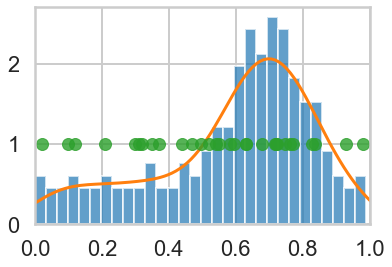

In [12]:
plt.hist(x, normed=True, bins=30, alpha=0.7)
sns.kdeplot(x)
plt.plot(x[indexes], [1.0]*len(indexes),'o', alpha=0.8)
plt.xlim([0,1]);

In our example, if we only want to use $g$, our estimand of $f$ to predict for large $x$, or more religious counties, we would need a good sampling of points $x$ closer to 1. And, similarly, the new $x$ we are using to make predictions would also need to be representative of those counties. We wont do well if we try and predict low-religiousness counties from a sample of high-religiousness ones. Or, if we do want to predict over the entire range of religiousness, our training sample better cover all $x$ well.

Our red points seem to follow our (god given) histogram well.

### Statement of the learning problem.

Once we have done that, we can then intuitively say that, if we find a hypothesis $g$ that minimizes the cost or risk over the training set; this hypothesis *might* do a good job over the population that the training set was representative of, since the risk on the population ought to be similar to that on the training set, and thus small.

Mathematically, we are saying that:

\begin{eqnarray*}
A &:& R_{\cal{D}}(g) \,\,smallest\,on\,\cal{H}\\
B &:& R_{out \,of \,sample} (g) \approx R_{\cal{D}}(g)
\end{eqnarray*}


In other words, we hope the **empirical risk estimates the out of sample risk well, and thus the out of sample risk is also small**.

Indeed, as we can see below, $g_{20}$ does an excellent job on the population, not just on the sample.

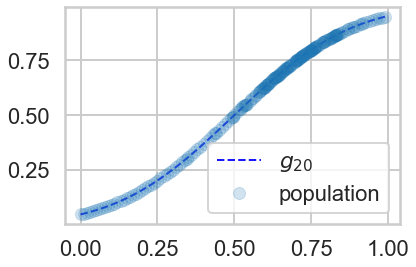

In [13]:
#plt.plot(x[indexes],f[indexes], 's', alpha=0.6, label="in-sample");
plt.plot(x,g20(x), 'b--', alpha=0.9, lw=2, label="$g_{20}$");
plt.plot(x,f, 'o', alpha=0.2, label="population");
plt.legend(loc=4);

##Noise

You probably noticed that I used weasel words like "might" and "hope" in the last section when saying that representative sampling in both training and test sets combined with ERM is what we need to learn a model. Let me give you a very simple counterexample: a prefect memorizer.

Suppose I construct a model which memorizes all the data points in the training set. Then its emprical risk is zero by definition, but it has no way of predicting anything on a test set. Thus it might as well choose the value at a new point randomly, and will perform very poorly. The process of interpolating a curve from points is precisely this memorization

We saw in the diagram above that $g_{20}$ did a very good job in capturing the curves of the population. However, note that the data obtained from $f$, our target, was still quite smooth. Most real-world data sets are not smooth at all, because of various effects such as measurement errors, other co-variates, and so on. Such **stochastic noise** plays havoc with our fits, as we shall see soon.

###Stochastic Noise, or the problem with randomness.

Stochastic noise bedevils almost every data set known to humans, and happens for many different reasons. 

Consider for example two customers of a bank with identical credit histories and salaries. One defaults on their mortgage, and the other does not. In this case we have identical $x = (credit, salary)$ for these two customers, but different $y$, which is a variable that is 1 if the customer defaulted and 0 otherwise. The true $y$ here might be a function of other co-variates, such as marital strife, sickness of parents, etc. But, as the bank, we might not have this information. So we get different $y$ for different customers at the information $x$ that we possess.

A similar thing might be happen in the election example, where we have modelled the probability of voting for romney as a function of religiousness of the county. There are many other variables we might not have measured, such as the majority race in that county.  But, we have not measured this information. Thus, in counties with high religiousness fraction $x$ we might have more noise than in others. Consider for example two counties, one with $x=0.8$ fraction of self-identified religious people in the county, and another with $x=0.82$. Based on historical trends, if the first county was mostly white, the fraction of those claiming they would vote for Romney might be larger than in a second, mostly black county. Thus you might have two very $y$'s next to each other on our graphs.

It gets worse. When pollsters estimate the number of people voting for a particular candidate, they only use finite samples of voters. So there is a 4-6\% polling error in any of these estimates. This "sampling noise" adds to the noisiness of the $y$'s. 


Indeed, we wish to estimate a function $f(x)$ so that the values $y_i$ come from the function $f$. Since we are trying to estimate f with data from only some counties, and furthermore, our estimates of the population behaviour in these counties will be noisy, our estimate wont be the "god given" or "real" f, but rather some **noisy** estimate of it. 

Lets simulate these errors to see how they affect the process of learning.

In [14]:
sigma=0.06
mask=(x > 0.65) & (x < 0.8)
sigmalist=sigma+mask*0.03

In [15]:
y = f + sp.stats.norm.rvs(scale=sigmalist, size=200)
#the next three lines just ensure that y remains a probability
yadd = (y < 0.0) *(0.01-y)
ysub = (y > 1.0)*(y - 1.0)
y = y + yadd -ysub

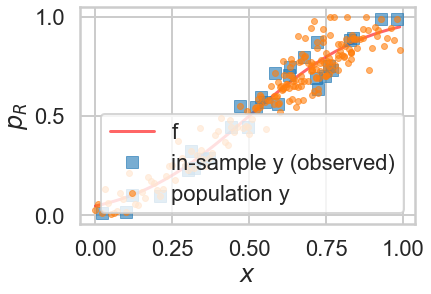

In [16]:
plt.plot(x,f, 'r-', alpha=0.6, label="f");
plt.plot(x[indexes], y[indexes], 's', alpha=0.6, label="in-sample y (observed)");
plt.plot(x, y, '.', alpha=0.6, label="population y");
plt.xlabel('$x$');
plt.ylabel('$p_R$')
plt.legend(loc=4);

In the figure above, one can see the scatter of the $y$ population about the curve of $f$. The errors of the 30 observation points ("in-sample") are shown as squares. One can see that observations next to each other can now be fairly different, as we descibed above.

### Systematic error

There is yet another class of errors called **systematic errors**. For example, sampling of respondents for an election might be done poorly. For example, if you were to only call people with land-lines to ask such questions, your respondents would likely skew older. And you would have a sampling bias in your polls. In the 2012 poll cycle, Rasmunnsen had a systematic bias in favor of republicans which had to be corrected for by various forecasters.^[http://fivethirtyeight.blogs.nytimes.com/2012/11/10/which-polls-fared-best-and-worst-in-the-2012-presidential-race/?_r=0].

Similarly, in observing or experimenting with physical phenomenon, the measuring instruments might have a systematic error. For example, an altimeter needs to be callibrated to an altitude correcly. If you do this wrong, you will have wrong altitudes (by the same amount) everywhere. Also, if the weather changes while you are at that original altitude, you might lose that original callibration (since altimeters rely on air pressure, the altimeter will think you've moved to a different altitude). As another example, if a measuting rope has stretched out, your yardage  measurements on a football field might be different.

These sorts of errors cannot be modelled statistically and need to be dealt with on a case by case basis. They are not what we are talking about here, but as a modeler, you must be alert to their possibility or prescence.

##Fitting a noisy model: the complexity of your hypothesis

Let us now try and fit the noisy data we simulated above, both using straight lines ($\cal{H}_1$), and 20th order polynomials($\cal{H}_{20}$). 

What we have done is introduced a noisy target $y$, so that

$$y = f(x) + \epsilon\,,$$

where $\epsilon$ is a **random** noise term that represents the stochastic noise. In the simulation of errors above we assumed that $\epsilon$ is drawn from a bell curve. Note that this means that $\epsilon$ will be different at different $x$, with its values chosen from a bell curve.

Another way to think about a noisy $y$ is to imagine that our data is generated from a joint probability distribution $P(x,y)$. In our earlier case with no stochastic noise, once you knew $x$, if I were to give you $f(x)$, you could give me $y$ exactly. This is now not possible because of the noise $\epsilon$: we dont know exactly how much noise we have at any given $x$. Thus we need to model $y$ at a given $x$, written as $P(y|x)$, as well using a probability distribution (a bell curve in our example). Since $P(x)$ is also a probability distribution, we have:

$$P(x,y) = P(y | x) P(x) .$$

Now the entire learning problem can be cast as a problem in probability **density estimation**: if we can estimate $P(x,y)$ and take actions based on that estimate thanks to our risk or error functional, we are done. More on this in the notebook on classification.

We now fit in both $\cal{H}_1$ and $\cal{H}_{20}$ to find the best fit straight line and best fit 20th order polynomial respectively.

In [17]:
g1noisy = np.poly1d(np.polyfit(x[indexes],y[indexes],1))
g20noisy = np.poly1d(np.polyfit(x[indexes],y[indexes],20))

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


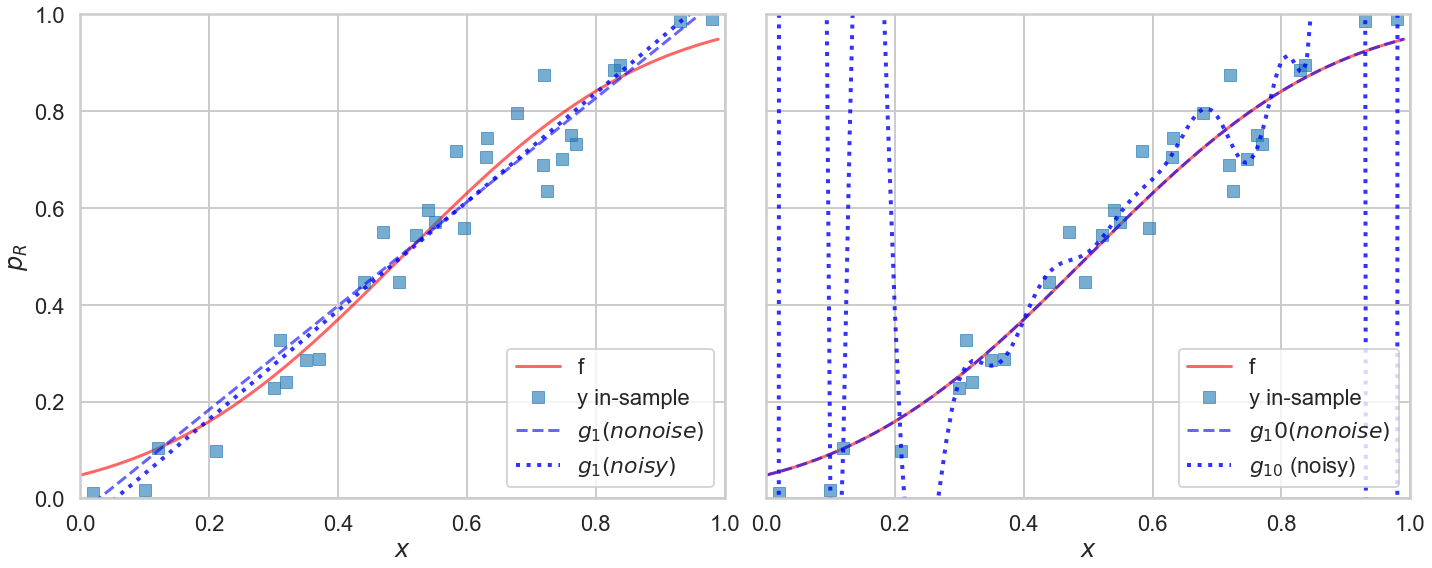

In [18]:
axes=make_plot()
axes[0].plot(x,f, 'r-', alpha=0.6, label="f");
axes[1].plot(x,f, 'r-', alpha=0.6, label="f");
axes[0].plot(x[indexes],y[indexes], 's', alpha=0.6, label="y in-sample");
axes[1].plot(x[indexes],y[indexes], 's', alpha=0.6, label="y in-sample");
axes[0].plot(x,g1(x),  'b--', alpha=0.6, label="$g_1 (no noise)$");
axes[0].plot(x,g1noisy(x), 'b:', lw=4, alpha=0.8, label="$g_1 (noisy)$");
axes[1].plot(x,g20(x),  'b--', alpha=0.6, label="$g_10 (no noise)$");
axes[1].plot(x,g20noisy(x), 'b:', lw=4, alpha=0.8, label="$g_{10}$ (noisy)");
axes[0].legend(loc=4);
axes[1].legend(loc=4);

The results are (to put it mildly) very interesting. 

Lets look at the figure on the left first. The noise changes the best fit line by a little but not by much. The best fit line still does a very poor job of capturing the variation in the data.

The best fit 20th order polynomial, in the presence of noise, is very interesting. It tries to follow all the curves of the observations..in other words, it tries to fit the noise. This is a disaster, as you can see if you plot the population (out-of-sample) points on the plot as well:

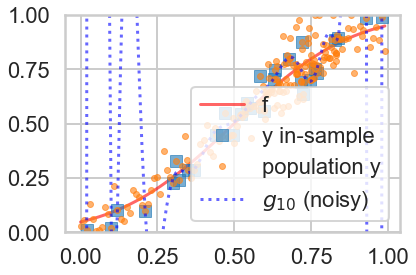

In [19]:
plt.plot(x,f, 'r-', alpha=0.6, label="f");
plt.plot(x[indexes],y[indexes], 's', alpha=0.6, label="y in-sample");
plt.plot(x,y,  '.', alpha=0.6, label="population y");
plt.plot(x,g20noisy(x), 'b:', alpha=0.6, label="$g_{10}$ (noisy)");
plt.ylim([0,1])
plt.legend(loc=4);

Whoa. The best-fit 20th order polynomial does a reasonable job fitting the in-sample data, and is even well behaved in the middle where we have a lot of in-sample data points. But at places with less in-sample data points, the polynomial wiggles maniacally.

This fitting to the noise is a danger you will encounter again and again in learning. Its called **overfitting**. So, $\cal{H}_{20}$ which seemed to be such a good candidate hypothesis space in the absence of noise, ceases to be one. The take away lesson from this is that we must further ensure that our **model does not fit the noise**.

Lets make a plot similar to the one we made for the deterministic noise earlier, and compare the error in the new $g_1$ and $g_20$ fits on the noisy data.

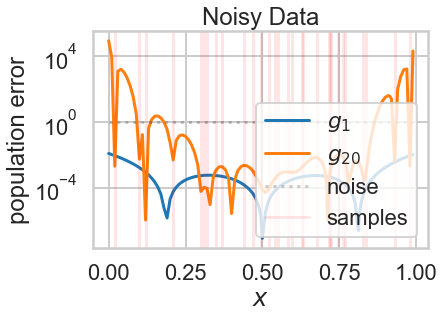

In [20]:
plt.plot(x, ((g1noisy(x)-f)**2), lw=3, label="$g_1$")
plt.plot(x, ((g20noisy(x)-f)**2), lw=3,label="$g_{20}$");
plt.plot(x, [1]*x.shape[0], "k:", label="noise", alpha=0.2);
for i in indexes[:-1]:
    plt.axvline(x[i], 0, 1, color='r', alpha=0.1)
plt.axvline(x[indexes[-1]], 0, 1, color='r', alpha=0.1, label="samples")
plt.xlabel("$x$")
plt.ylabel("population error")
plt.yscale("log")
plt.legend(loc=4);
plt.title("Noisy Data");

$g_1$ now, for the most part, has a lower error! So you'd be better off by having chosen a set of models with much more bias (the straight lines, $\cal{H}_1$) than a more complex model set ($\cal{H}_{20}$) in the case of noisy data. 

###The Variance of your model

This tendency of a more complex model to overfit, by having enough freedom to fit the noise, is described by something called high **variance**. What is variance?

Variance, simply put, is the "error-bar" or spread in models that would be learnt by training on different data sets $\cal{D}_1, \cal{D}_2,...$ drawn from the population. Now, this seems like a circular concept, as in real-life, you do not have access to the population. But since we simulated our data here anyways, we do, and so let us see what happens if we choose **different 30 points randomly from our population of 200**, and fit models in both $\cal{H}_1$ and $\cal{H}_{20}$ to them. We do this on 200 sets of randomly chosen (from the population) data sets of 30 points each and plot the best fit models in noth hypothesis spaces for all 200 sets.

In [21]:
def gen(degree, nsims, size, x, out):
    outpoly=[]
    for i in range(nsims):
        indexes=np.sort(np.random.choice(x.shape[0], size=size, replace=False))
        pc=np.polyfit(x[indexes], out[indexes], degree)
        p=np.poly1d(pc)
        outpoly.append(p)
    return outpoly

In [22]:
polys1 = gen(1, 200, 30,x, y);
polys20 = gen(20, 200, 30,x, y);

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: Ran

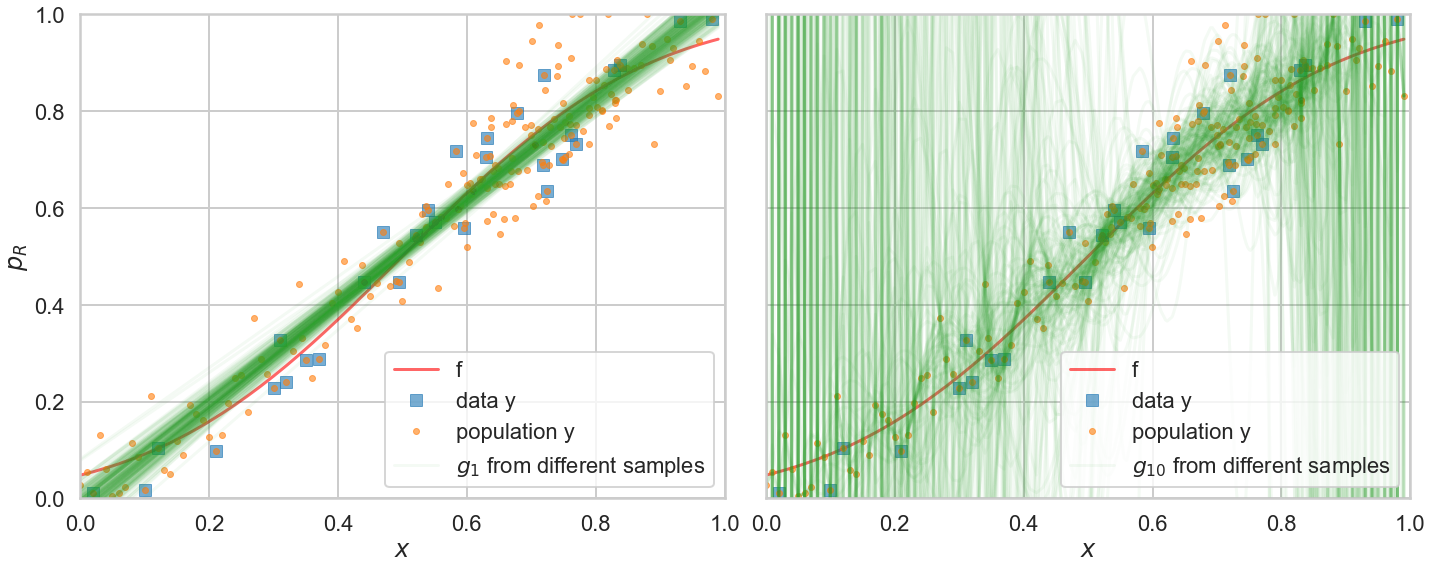

In [23]:
axes=make_plot()
axes[0].plot(x,f, 'r-', lw=3, alpha=0.6, label="f");
axes[1].plot(x,f, 'r-', lw=3, alpha=0.6, label="f");
axes[0].plot(x[indexes], y[indexes], 's', alpha=0.6, label="data y");
axes[1].plot(x[indexes], y[indexes], 's', alpha=0.6, label="data y");
axes[0].plot(x, y, '.', alpha=0.6, label="population y");
axes[1].plot(x, y, '.', alpha=0.6, label="population y");
c=sns.color_palette()[2]
for i,p in enumerate(polys1[:-1]):
    axes[0].plot(x,p(x), alpha=0.05, c=c)
axes[0].plot(x,polys1[-1](x), alpha=0.05, c=c,label="$g_1$ from different samples")
for i,p in enumerate(polys20[:-1]):
    axes[1].plot(x,p(x), alpha=0.05, c=c)
axes[1].plot(x,polys20[-1](x), alpha=0.05, c=c, label="$g_{10}$ from different samples")
axes[0].legend(loc=4);
axes[1].legend(loc=4);

On the left panel, you see the 200 best fit straight lines, each a fit on a different 30 point training sets from the 200 point population. The best-fit lines bunch together, even if they dont quite capture $f$ (the thick red line) or the data (squares) terribly well.

On the right panel, we see the same with best-fit models chosen from $\cal{H}_{20}$. It is a diaster. While most of the models still band around the central trend of the real curve $f$ and data $y$ (and you still see the waves corresponding to all too wiggly 20th order polynomials), a substantial amount of models veer off into all kinds of noisy hair all over the plot. This is **variance**: the the predictions at any given $x$ are all over the place.

The variance can be seen in a different way by plotting the coefficients of the polynomial fit. Below we plot the coefficients of the fit in $\cal{H}_1$. The variance is barely 0.2 about the mean for both co-efficients.

In the right panel we plot the coefficients of the fit in $\cal{H}_{20}$. This is why we use the word "variance": the spread in the values of the middle coefficients about their means (dashed lines) is of the order $10^{10}$ (the vertical height of the bulges), with huge outliers!! The 20th order polynomial fits are a disaster!


So far?

- you have learnt the basic formulation of the learning problem, the concept of a hypothesis space, and a strategy using minimization of distance (called cost or risk) to find the best fit model for the target function from this hypothesis space. 
- You learned the effect of noise on this fit, and the issues that crop up in learning target functions from data, chiefly the problem of overfitting to this noise. 


The process of learning has two parts:

1. Fit for a model by minimizing the in-sample risk
2. Hope that the in-sample risk approximates the out-of-sample risk well.

Well, we are scientists. Just hoping does not befit us. But we only have a sample. What are we to do?

The "aha" moment comes when we realize that we can hold back some of our sample, and test the performance of our learner by trying it out on this held back part! Perhaps we can compute the error or risk on the held-out part, or "test" part of our sample, and have something to say about the out-of-sample error.

##Testing and Training Sets

In [24]:
df=pd.DataFrame(dict(x=x[indexes],f=f[indexes],y=y[indexes]))

In [25]:
from sklearn.model_selection import train_test_split
datasize=df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(range(30),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

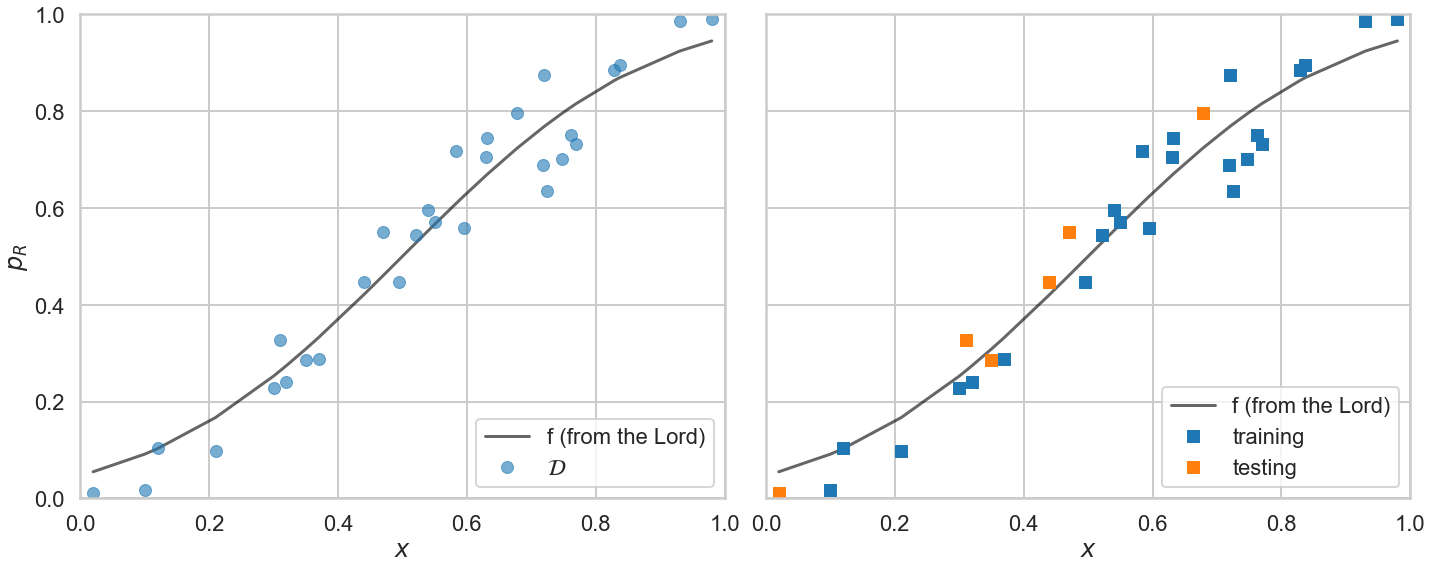

In [26]:
axes=make_plot()
axes[0].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[0].plot(df.x,df.y, 'o',alpha=0.6, label="$\cal{D}$");
axes[1].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[1].plot(xtrain, ytrain, 's', label="training")
axes[1].plot(xtest, ytest, 's', label="testing")
axes[0].legend(loc="lower right")
axes[1].legend(loc="lower right")

###A short digression about scikit-learn

In [27]:
from sklearn.preprocessing import PolynomialFeatures
PolynomialFeatures(3).fit_transform([[1],[2], [3]])

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.]])

In [28]:
np.array([1,2,3]).reshape(-1,1)

array([[1],
       [2],
       [3]])

So now we are in the recatangular, rows=samples, columns=features form expected by `scikit-learn`. Ok, so lets see the process to transform our 1-D dataset `x` into a d-dimensional one. 

In [29]:
xtrain

array([0.63166321, 0.76128927, 0.21      , 0.32      , 0.12      ,
       0.54      , 0.83724472, 0.3       , 0.72      , 0.5833461 ,
       0.49504505, 0.59516207, 0.74699252, 0.82850909, 0.77      ,
       0.1       , 0.52125572, 0.63      , 0.37      , 0.72432865,
       0.71829603, 0.93      , 0.98      , 0.55      ])

In [30]:
xtrain.reshape(-1,1)

array([[0.63166321],
       [0.76128927],
       [0.21      ],
       [0.32      ],
       [0.12      ],
       [0.54      ],
       [0.83724472],
       [0.3       ],
       [0.72      ],
       [0.5833461 ],
       [0.49504505],
       [0.59516207],
       [0.74699252],
       [0.82850909],
       [0.77      ],
       [0.1       ],
       [0.52125572],
       [0.63      ],
       [0.37      ],
       [0.72432865],
       [0.71829603],
       [0.93      ],
       [0.98      ],
       [0.55      ]])

In [31]:
PolynomialFeatures(2).fit_transform(xtrain.reshape(-1,1))

array([[1.        , 0.63166321, 0.39899842],
       [1.        , 0.76128927, 0.57956135],
       [1.        , 0.21      , 0.0441    ],
       [1.        , 0.32      , 0.1024    ],
       [1.        , 0.12      , 0.0144    ],
       [1.        , 0.54      , 0.2916    ],
       [1.        , 0.83724472, 0.70097872],
       [1.        , 0.3       , 0.09      ],
       [1.        , 0.72      , 0.5184    ],
       [1.        , 0.5833461 , 0.34029267],
       [1.        , 0.49504505, 0.2450696 ],
       [1.        , 0.59516207, 0.35421789],
       [1.        , 0.74699252, 0.55799782],
       [1.        , 0.82850909, 0.68642731],
       [1.        , 0.77      , 0.5929    ],
       [1.        , 0.1       , 0.01      ],
       [1.        , 0.52125572, 0.27170752],
       [1.        , 0.63      , 0.3969    ],
       [1.        , 0.37      , 0.1369    ],
       [1.        , 0.72432865, 0.52465199],
       [1.        , 0.71829603, 0.51594919],
       [1.        , 0.93      , 0.8649    ],
       [1.

Lets put this alltogether. Below we create multiple datasets, one for each polynomial degree:

In [32]:
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

###How do training and testing error change with complexity?

You will recall that the big question we were left with earlier is: what order of polynomial should we use to fit the data? Which order is too biased? Which one has too much variance and is too complex? Let us try and answer this question.

We do this by fitting 14 different models (remember the fit is made by minimizing the empirical risk on the training set), each with increasing dimension `d`, and looking at the training-error and the test-error in each of these models. So we first try $\cal{H}_0$, then $\cal{H}_1$, then $\cal{H}_2$, and so on.

Since we use `PolynomialFeatures` above, each increasing dimension gives us an additional feature. $\cal{H}_5$ has 6 features, a constant and the 5 powers of `x`. What we want to do is to find the coefficients of the 5-th order polynomial that best fits the data. Since the polynomial is **linear** in the coefficients (we multiply coefficients by powers-of-x features and sum it up), we use a learner called a `LinearRegression` model (remember that the "linear" in the regression refers to linearity in co-efficients). The scikit-learn interface to make such a fit is also very simple, the function `fit`. And once we have learned a model, we can predict using the function `predict`. The API paper again:

>The predictor interface extends the notion of an estimator by adding a predict method that takes an array X_test and produces predictions for X_test, based on the learned parameters of the estimator.

So, for increasing polynomial degree, and thus feature dimension `d`, we fit a `LinearRegression` model on the traing set. We then use scikit-learn again to calculate the error or risk. We calculate the `mean_squared_error` between the model's predictions and the data, BOTH on the training set and test set. We plot this error as a function of the defree of the polynomial `d`.

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees=range(21)
error_train=np.empty(len(degrees))
error_test=np.empty(len(degrees))

traintestlists=make_features(xtrain, xtest, degrees)

####The structure of `scikit-learn`

Once again, lets see the structure of scikit-learn needed to make these fits. `.fit` always takes two arguments:

`estimator.fit(Xtrain, ytrain)`.

Here `Xtrain` must be in the form of an array of arrays, with the inner array each corresponding to one sample, and whose elements correspond to the feature values for that sample. (This means that the 4th element for each of these arrays, in our polynomial example, corresponds to the valueof $x^3$ for each "sample" $x$). The `ytrain` is a simple array of responses..continuous for regression problems, and categorical values or 1-0's for classification problems.


In [34]:
traintestlists[3]['train'], ytrain

(array([[1.        , 0.63166321, 0.39899842, 0.25203262],
        [1.        , 0.76128927, 0.57956135, 0.44121384],
        [1.        , 0.21      , 0.0441    , 0.009261  ],
        [1.        , 0.32      , 0.1024    , 0.032768  ],
        [1.        , 0.12      , 0.0144    , 0.001728  ],
        [1.        , 0.54      , 0.2916    , 0.157464  ],
        [1.        , 0.83724472, 0.70097872, 0.58689073],
        [1.        , 0.3       , 0.09      , 0.027     ],
        [1.        , 0.72      , 0.5184    , 0.373248  ],
        [1.        , 0.5833461 , 0.34029267, 0.1985084 ],
        [1.        , 0.49504505, 0.2450696 , 0.12132049],
        [1.        , 0.59516207, 0.35421789, 0.21081705],
        [1.        , 0.74699252, 0.55799782, 0.4168202 ],
        [1.        , 0.82850909, 0.68642731, 0.56871127],
        [1.        , 0.77      , 0.5929    , 0.456533  ],
        [1.        , 0.1       , 0.01      , 0.001     ],
        [1.        , 0.52125572, 0.27170752, 0.1416291 ],
        [1.   

The test set `Xtest` has the same structure, and is used in the `.predict` interface. Once we have fit the estimator, we predict the results on the test set by:

`estimator.predict(Xtest)`.

The results of this are a simple array of predictions, of the same form and shape as `ytest`.

In [35]:
traintestlists[3]['test'], ytest

(array([[1.00000000e+00, 4.70000000e-01, 2.20900000e-01, 1.03823000e-01],
        [1.00000000e+00, 3.10000000e-01, 9.61000000e-02, 2.97910000e-02],
        [1.00000000e+00, 6.77893359e-01, 4.59539406e-01, 3.11518712e-01],
        [1.00000000e+00, 3.50000000e-01, 1.22500000e-01, 4.28750000e-02],
        [1.00000000e+00, 4.40000000e-01, 1.93600000e-01, 8.51840000e-02],
        [1.00000000e+00, 2.00000000e-02, 4.00000000e-04, 8.00000000e-06]]),
 array([0.54946231, 0.3264553 , 0.79619303, 0.28569945, 0.44630184,
        0.01      ]))

We can then use `mean_squared_error` from `sklearn` to calculate the error between the predictions and actual `ytest` values. Below we calculate this error on both the training set (which we already fit on) and the test set (which we hadnt seen before), and plot how these errors change with the degree of the polynomial.

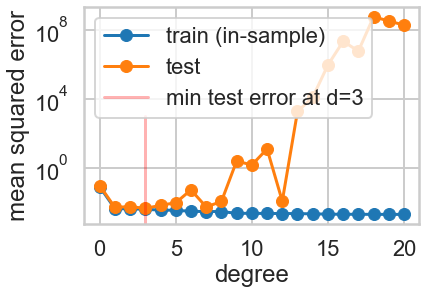

In [36]:
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = traintestlists[d]['train']
    Xtest = traintestlists[d]['test']
    #set up model
    est = LinearRegression()
    #fit
    est.fit(Xtrain, ytrain)
    #predict
    prediction_on_training = est.predict(Xtrain)
    prediction_on_test = est.predict(Xtest)
    #calculate mean squared error
    error_train[d] = mean_squared_error(ytrain, prediction_on_training)
    error_test[d] = mean_squared_error(ytest, prediction_on_test)

plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='test')
plt.axvline(np.argmin(error_test), 0,0.5, color='r', label="min test error at d=%d"%np.argmin(error_test), alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

The graph shows a very interesting structure. The training error decreases with increasing degree of the polynomial. This ought to make sense given what you know now: one can construct an arbitrarily complex polynomial to fit all the training data: indeed one could construct an order 24 polynomial which perfectly interpolates the 24 data points in the training set. You also know that this would do very badly on the test set as it would wiggle like mad to capture all the data points. And this is indeed what we see in the test set error. 

For extremely low degree polynomials like $d=0$ a flat line capturing the mean value of the data or $d=1$ a straight line fitting the data, the polynomial is not curvy enough to capturve the conbtours of the data. We are in the bias/deterministic error regime, where we will always have some difference between the data and the fit since the hypothesis is too simple. But, for degrees higher than 4, the polynomial starts to wiggle too much to capture the training data. The test set error increases as the predictive power of the polynomial goes down thanks to the contortions it must endure to fit the training data.

Thus the test set error first decreases as the model get more expressive, and then, once we exceed a certain level of complexity (here indexed by $d$), it increases. This idea can be used to identify just the right amount of complexity in the model by picking as **the best hypothesis as the one that minimizes test set error** or risk. In our case this happens at $d=4$. (This exact number will depend on the random points chosen into the training and test sets) For complexity lower than this critical value, identified by the red vertical line in the diagram, the hypotheses underfit; for complexity higher, they overfit.

![m:caption](images/complexity-error-plot.png)

##Validation

There is a problem with the process above which is not apparent at first look. What we have done in picking $d=4$ as the best hypothesis is that we have used the test set as a training set. How?

Our process used the training set to fit for the **parameters**(values of the coefficients) of the polynomial of given degree $d$ based on minimizing the traing set error (empirical risk minimization). We then calculated the error on the test set at that $d$. If we go further and choose the best $d$ based on minimizing the test set error, we have then "fit for" $d$ on the test set. We will thus call $d$ a **hyperparameter** of the model.

In this case, the test-set error will underestimate the true out-of-sample error (for a proof of this see Abu-Mostafa, Yaser S., Malik Magdon-Ismail, and Hsuan-Tien Lin. Learning from data. AMLBook, 2012.). Furthermore, we have **contaminated the test set** by fitting for $d$ on it; it is no longer a true test set.

Thus, we must introduce a new **validation set** on which the complexity parameter $d$ is fit, and leave out a test set which we can use to estimate the true out-of-sample performance of our learner. The place of this set in the scheme of things is shown below:

![m:caption](images/train-validate-test.png)

We have split the old training set into a training set and a validation set, holding the old test aside for FINAL testing AFTER we have "fit" for complexity $d$. Obviously we have decreased the size of the data available for training further, but this is a price we must pay for obtaining a good estimate of the out-of-sample risk $\cal{E}_{out}$ (also denoted as risk $R_{out}$) through the test risk $\cal{E}_{test}$ ($R_{test}$).

![m:caption](images/train-validate-test-cont.png)

The validation process is illustrated in these two figures. We first loop ober all the hypothesis sets that we wish to consider: in our case this is a loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. Then for each degree $d$, we obtain a best fit model $g^-_d$ where the "minus" superscript indicates that we fit our model on the new training set which is obtained by removing ("minusing") a validation chunk (often the same size as the test chunk) from the old training set. We then "test" this model on the validation chunk, obtaining the validation error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the validation set errors, just like we did with the test errors earlier, and pick the degree $d_*$ which minimizes this validation set error.

![caption](images/train-validate-test3.png)

Having picked the hyperparameter $d_*$, we retrain using the hypothesis set $\cal{H}_{*}$ on the entire old training-set to find the parameters of the polynomial of order $d_*$ and the corresponding best fit hypothesis $g_*$. Note that we left the minus off the $g$ to indicate that it was trained on the entire old traing set. We now compute the test error on the test set as an estimate of the test risk $\cal{E}_{test}$.

Thus the **validation** set if the set on which the hyperparameter is fit. This method of splitting the data $\cal{D}$ is called the **train-validate-test** split.

We carry out this process for one training/validation split below. Note the smaller size of the new training set. We hold the test set at the same size.

5


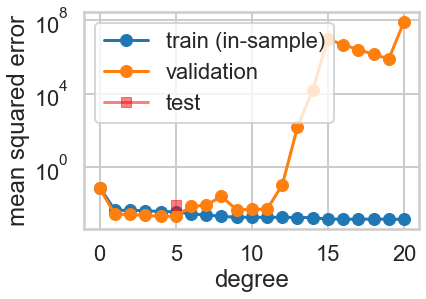

In [38]:
#we split the training set down further
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= df.x[intrain].values
fntrain = df.f[intrain].values
yntrain = df.y[intrain].values
xnvalid= df.x[invalid].values
fnvalid = df.f[invalid].values
ynvalid = df.y[invalid].values

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the new smaller training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #predict on new training and validation sets and calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

#calculate the degree at which validation error is minimized
mindeg = np.argmin(error_valid) 
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
#predict on the test set now and calculate error
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(ytest, pred)
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")
print (mindeg)

We obtained a validation set minimizing polynomial degree of 4.

Lets do this again, choosing a new random split between training and validation data: 

2


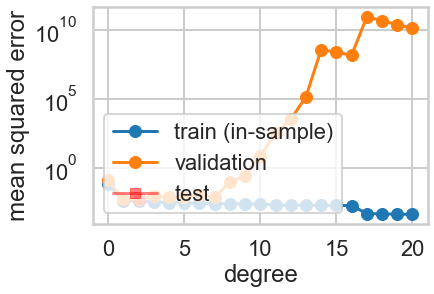

In [40]:
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= df.x[intrain].values
fntrain = df.f[intrain].values
yntrain = df.y[intrain].values
xnvalid= df.x[invalid].values
fnvalid = df.f[invalid].values
ynvalid = df.y[invalid].values

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

mindeg = np.argmin(error_valid)
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(ytest, pred)
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')

plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='lower left')
plt.yscale("log")
print (mindeg)

This time the validation error minimizing polynomial degree changed! What happened?

##Cross Validation

###The Idea

Remember that we chose a new random split? Since we are dealing with small data sizes here, you should worry that this exposes us to the peciliarity of the data set that got randomly chosen for us. This naturally leads us to want to choose multiple such random splits and somehow average over this process to find the "best" validation minimizing polynomial degree or complexity $d$.

Furthermore the validation set that we left out has two competing demands on it. The larger the set is, the better is our estimate of the out-of-sample error. So we'd like to hold out as much as possible.

But the smaller the validation set is, the more data we have to train ourmodel on. Thus we can fit a better, more expressive model.

We want to balance these two desires, and additionally, not be exposed to any peculiarities that might randomly arise in any single train-validate split of the old training set.

To deal with this we engage in a process called **cross-validation**, which is illustrated in the figure below, for a given hypothesis set $\cal{H}_a$ with complexity parameter $d=a$ (the polynomial degree). We do the train/validate split, not once but multiple times. 

In the figure below we create 4-folds from the training set part of our data set $\cal{D}$. By this we mean that we divide our set roughly into 4 equal parts. As illustrated below, this can be done in 4 different ways, or folds. In each fold we train a model on 3 of the parts. The model so trained is denotet as $g^-_{Fi}$, for example $g^-_{F3}$ . The minus sign in the superscript once again indicates that we are training on a reduced set. The $F3$ indicates that this model was trained on the third fold. Note that the model trained on each fold will be different!

For each fold, after training the model, we calculate the risk or error on the remaining one validation part. We then add the validation errors together from the different folds, and divide by the number of folds to calculate an average error. Note again that this average error is an average over different models $g^-_{Fi}$. We use this error as the validation error for $d=a$ in the validation process described earlier.

![m:caption](images/train-cv2.png)

Note that the number of folds is equal to the number of splits in the data. For example, if we have 5 splits, there will be 5 folds. To illustrate cross-validation consider below fits in $\cal{H}_0$ and $\cal{H}_1$ (means and straight lines) to a sine curve, with only 3 data points.

###The entire description of K-fold Cross-validation

We put thogether this scheme to calculate the error for a given polynomial degree $d$ with the method we used earlier to choose a model given the validation-set risk as a function of $d$:

1. create `n_folds` partitions of the training data. 
2. We then train on `n_folds -1` of these partitions, and test on the remaining partition. There are `n_folds` such combinations of partitions (or folds), and thus we obtain `n_fold` risks.
3. We average the error or risk of all such combinations to obtain, for each value of $d$, $R_{dCV}$.
4. We move on to the next value of $d$, and repeat 3
5. and then find the optimal value of d that minimizes risk $d=*$.
5. We finally use that value to make the final fit in $\cal{H}_*$ on the entire old training set.

![caption](images/train-cv3.png)

It can also shown that **cross-validation error is an unbiased estimate of the out of sample-error**.

Let us now do 4-fold cross-validation on our Romney votes data set. We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split in 4 ways into 4 folds, train on 3 folds, and calculate the validation error on the ramining one. We then average the erros over the four folds to get a cross-validation error for that $d$. Then we did what we did before: find the hypothesis space $\cal{H}_*$ with the lowest cross-validation error, and refit it using the entire training set. We can then use the test set to estimate $E_{out}$.

In [49]:
from sklearn.model_selection import KFold
n_folds=4
degrees=range(21)
results=[]
fold = KFold(n_folds,shuffle = False)
for d in degrees:
    hypothesisresults=[]
    for train, test in fold.split(xtrain): # split data into train/test groups, 4 times
        tvlist=make_features(xtrain[train], xtrain[test], degrees)
        clf = LinearRegression()
        
        clf.fit(tvlist[d]['train'], ytrain[train]) # fit
        hypothesisresults.append(mean_squared_error(ytrain[test], clf.predict(tvlist[d]['test']))) # evaluate score function on held-out data
    results.append((np.mean(hypothesisresults), np.min(hypothesisresults), np.max(hypothesisresults))) # average

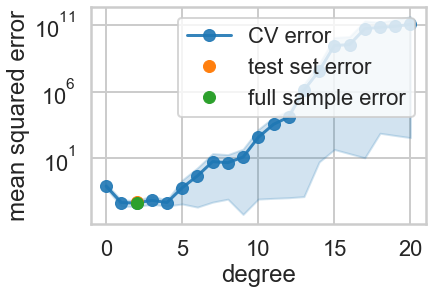

In [50]:
mindeg = np.argmin([r[0] for r in results])
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(pred, ytest)
errtr=mean_squared_error(ytrain, clf.predict(ttlist[mindeg]['train']))
errout=0.8*errtr+0.2*err
c0=sns.color_palette()[0]
#plt.errorbar(degrees, [r[0] for r in results], yerr=[r[1] for r in results], marker='o', label='CV error', alpha=0.5)
plt.plot(degrees, [r[0] for r in results], marker='o', label='CV error', alpha=0.9)
plt.fill_between(degrees, [r[1] for r in results], [r[2] for r in results], color=c0, alpha=0.2)
plt.plot([mindeg], [err], 'o',  label='test set error')
plt.plot([mindeg], [errout], 'o',  label='full sample error')


plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper right')
plt.yscale("log")

We see that the cross-validation error minimizes at a low degree, and then increases. Because we have so few data points the spread in fold errors increases as well.

##Regularization

Upto now we have focussed on finding the polynomial with the right degree of complecity $d=*$ given the data that we have.

Let us now ask a different question: if we are going to fit the data with an expressive model such as 20th order polynomials, how can we **regularize** or smooth or restrict the choices of the kinds of 20th order polynomials that we allow in our fits. In other words, we are again trying to bring down the complexity of the hypothesis space, but by a different tack: a tack which prefers smooth polynomials over wiggly ones.

That is, if we want to fit with a 20th order polynomial, ok, lets fit with it, but lets reduce the size of, or limit the functions in $\cal{H}_{20}$ that we allow.

In a sense we have already done this, havent we? When we compared $\cal{H}_1$ over $\cal{H}_{10}$, we imposed a **hard constraint** by setting all polynomial co-efficients for terms higher than $x$ to 0. Instead we might want to set a **soft constraint** by setting:

$$\sum_{i=0}^j a_i^2 < C.$$

We can do this by adding a term to the empirical risk that we minimize on the training data for $\cal{H}_j$ (seeing why is beyond the scope of this lab but google on lagrange multipliers and the dual problem):

$$\cal{R}(h_j) =  \sum_{y_i \in \cal{D}} (y_i - h_j(x_i))^2 +\alpha \sum_{i=0}^j a_i^2.$$

This new risk takes the empirical risk and adds a "penalty term" to it to minimize overfitting. The term is proportional to the sum of the squares of the coefficients and is positive, so it will keep their values down

Notice that we are adding a term to the **training error**, once $\alpha$ is defined. The entire structure is similar to what we did to find the optimal $d=*$, with $\alpha$ being the analog of $d$. And thus we can use the same validation and cross-validation technology that we developed to estimate $d$.

This technique is called **regularization** or **shrinkage** as it takes the coefficients $a_i$ towards smaller sizes. As you have seen earlier, for polynomials this corresponds to choosing smooth functions over wiggly functions. When $\alpha=0$ we have the regular polynomial regression problem, and if we are using 20th order polynomials we will wildly overfit. We are in the high variance zone. The problem with a non-zero $\alpha$ is called **ridge regression**. As $\alpha$ increases, the importance of the penalty term increases at the expense of the ERM term, and we are pushed to increase the smoothness of the polynomials. When $\alpha$ becomes very large the penalty term dominates and we get into the high bias zone. Thus $\alpha$ acts as a complexity parameter just like $d$ did, with high complexity being $\alpha \to 0$.

Let us illustrate the concept of regularization using the example of the sine wave. This time we shall consider fits using the straight lines in $\cal{H}_1$. Once again we fit a straight line to 3 points, choosing 100 such set of 3 points from the data set.

(100, 3)


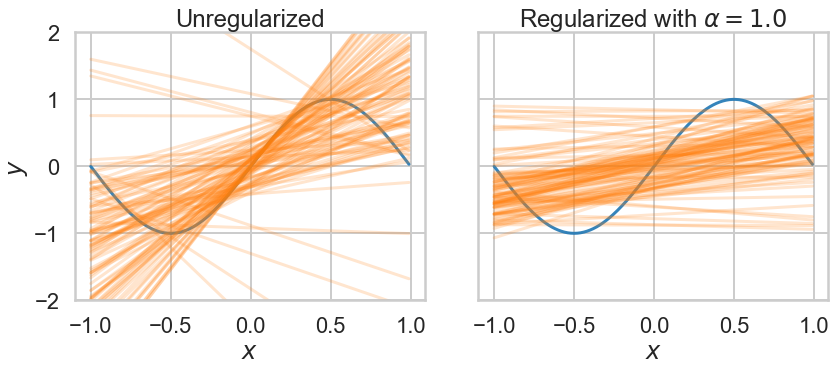

In [52]:
xs=np.arange(-1.,1.,0.01)
ff = lambda x: np.sin(np.pi*x)
ffxs=ff(xs)
from sklearn.linear_model import Ridge
axes=make_simple_plot()
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
axes[0].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)
axes[1].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)
from sklearn.linear_model import Ridge
D=np.empty((100,3), dtype="int")
print (D.shape)
for i in range(100):
    D[i,:] = np.random.choice(200, replace=False, size=3)
for i in range(100):
    choices = D[i,:]
    p1=np.polyfit(xs[choices], ffxs[choices],1)
    est = Ridge(alpha=1.0)
    est.fit(xs[choices].reshape(-1,1), ffxs[choices])
    axes[0].plot(xs, np.polyval(p1, xs), color=c1, alpha=0.2)
    axes[1].plot(xs, est.predict(xs.reshape(-1,1)), color=c1, alpha=0.2)
axes[0].set_title("Unregularized");
axes[1].set_title("Regularized with $\\alpha=1.0$");

In the left panel we plot unregularized straight line fits. The plot is hairy, since choosing 3 points from 200 between -1 and 1 dosent constrain the lines much at all. On the right panel, we plot the output of **Ridge** regression with $\alpha=1$. This corresponds to adding a term to the empirical risk of $\alpha\, (a_0^2 + a_1^2)$ where $a_0$ and $a_1$ are the intercept and slope of the line respectively. Notice that the lines are much more constrained  in this second plot. The penalty term has regularized the values of the intercept and slope, and forced the intercept to be closer to 0 and the lines to be flatter.

###Regularization of the Romney model with Cross-Validation

In [53]:
def plot_functions(est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", alpha=0.4)
    ax.plot(xtest, ytest, 's', label="testing", alpha=0.6)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX),  '.', label="alpha = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')
    
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="alpha = %s" % str(alpha))
    ax.set_ylim((1e-1, 1e15))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left')

Lets now go back to the Romney voting model and see what regularization does to the fits in that model. The addition of a penalty term to the risk or error causes us to choose a smaller subset of the entire set of complex $\cal{H}_{20}$ polynomials. This is shown in the diagram below where the balance between bias and variance occurs at some subset $S_*$ of the set of 20th order polynomials indexed by $\alpha_*$ (there is an error on the diagram, the 13 there should actually be a 20).

![m:caption](images/complexity-error-reg.png)

Lets see what some of the $\alpha$s do. The diagram below trains on the entire training set, for given values of $\alpha$, minimizing the penalty-term-added training error.

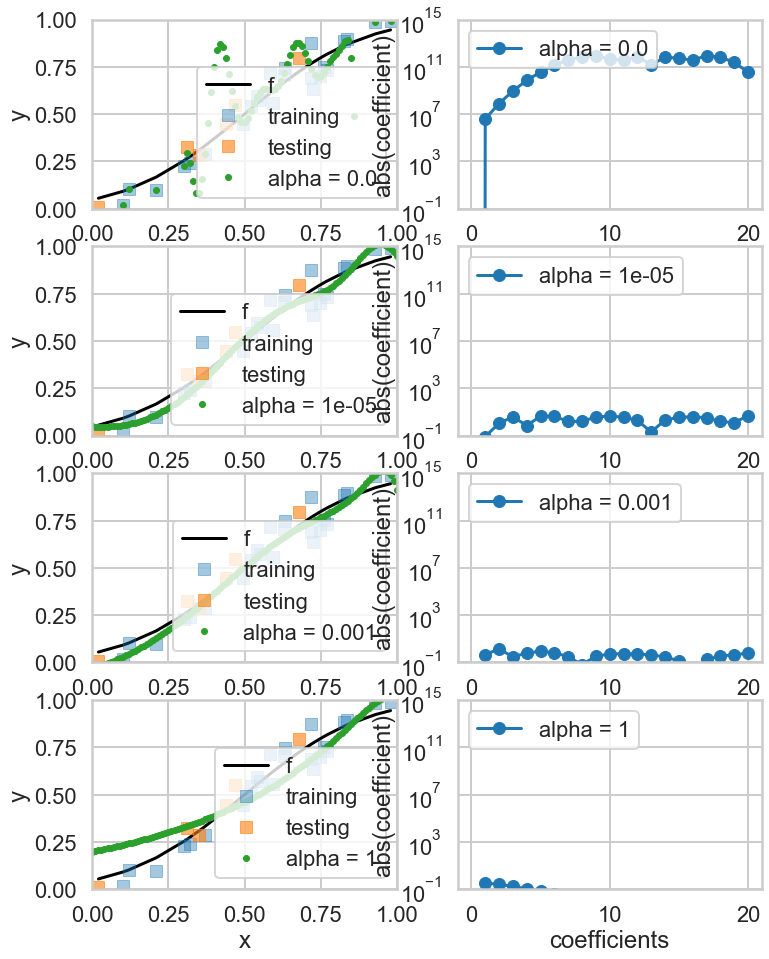

In [54]:
fig, rows = plt.subplots(4, 2, figsize=(12, 16))
d=20
alphas = [0.0, 1e-5, 1e-3, 1]
Xtrain = traintestlists[d]['train']
Xtest = traintestlists[d]['test']
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Ridge(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)

As you can see, as we increase $\alpha$ from 0 to 1, we start out overfitting, then doing well, and then, our fits, develop a mind of their own irrespective of data, as the penalty term dominates the risk.

Lets use cross-validation to figure what this critical $\alpha_*$ is. To do this we use the concept of a *meta-estimator* from scikit-learn. As the API paper puts it:

>In scikit-learn, model selection is supported in two distinct meta-estimators, GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier=GridSearchCV(clf, param_grid=parameters, cv=4, scoring="mean_squared_error")
    
The `GridSearchCV` replaces the manual iteration over thefolds using `KFolds` and the averaging we did previously, doint it all for us. It takes a parameter grid in the shape of a dictionary as input, and sets $\alpha$ to the appropriate parameter values one by one. It then trains the model, cross-validation fashion, and gets the error. Finally it compares the errors for the different $\alpha$'s, and picks the best choice model.

In [60]:
from sklearn.metrics import make_scorer
#, 1e-6, 1e-5, 1e-3, 1.0
from sklearn.model_selection import GridSearchCV
def cv_optimize_ridge(X, y, n_folds=4):
    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="completeness_score")
    gs.fit(X, y)
    return gs

In [61]:
fitmodel = cv_optimize_ridge(Xtrain, ytrain, n_folds=4)

In [63]:
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.cv_results_

(Ridge(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 {'alpha': 1e-08},
 1.0,
 {'mean_fit_time': array([0.00124204, 0.00049871, 0.00026172, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.003905  ]),
  'std_fit_time': array([0.00043359, 0.00049871, 0.00045332, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.00676366]),
  'mean_score_time': array([0.03840208, 0.00124627, 0.00049859, 0.        , 0.00390601,
         0.        , 0.        , 0.        , 0.        , 0.        ]),
  'std_score_time': array([0.06480473, 0.00043219, 0.00049859, 0.        , 0.00676541,
         0.        , 0.        , 0.        , 0.        , 0.        ]),
  'param_alpha': masked_array(data=[1e-08, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001,
                     0.01, 0.1, 1.0],
               mask=[False, False, False, False, False, False, False, False,
     

Our best model occurs for $\alpha=0.01$. We also output the mean cross-validation error at different $\alpha$ (with a negative sign, as scikit-learn likes to maximize negative error which is equivalent to minimizing error).

We refit the estimator on old training set, and calculate and plot the test set error and the polynomial coefficients. Notice how many of these coefficients have been pushed to lower values or 0.

In [64]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [65]:
alphawechoose = fitmodel.best_params_['alpha']
clf = Ridge(alpha=alphawechoose).fit(Xtrain,ytrain)

In [66]:
err=mean_squared_error(clf.predict(Xtest), ytest)
errtr=mean_squared_error(clf.predict(Xtrain), ytrain)
errout=0.8*errtr+0.2*err

In [67]:
def plot_functions_onall(est, ax, df, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    #print est.predict(transX)
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

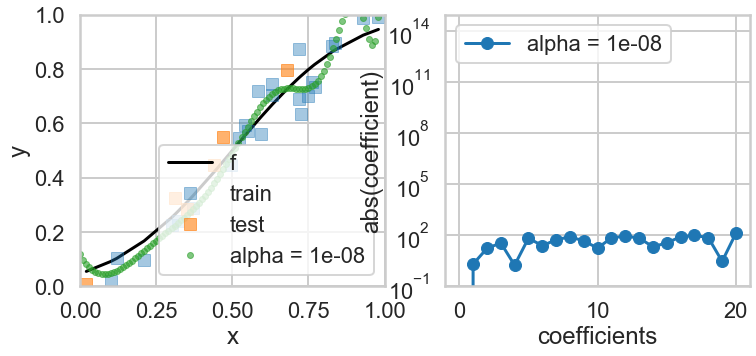

In [68]:
fig, rows = plt.subplots(1, 2, figsize=(12, 5))
l,r=rows
plot_functions_onall(clf, l, df, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(clf, r, alphawechoose)

As we can see, the best fit model is now chosen from the entire set of 20th order polynomials, and a non-zero hyperparameter $\alpha$ that we fit for ensures that only smooth models amonst these polynomials are chosen, by setting most of the polynomial coefficients to something close to 0 (Lasson sets them exactly to 0).

###What is minimized where?

Regularization adds a term to the error or risk, which is then, for fixed $\alpha$, minimized on the training set.
The validation error is then calculated on the validation set and reported alongside the value of $\alpha$ used. If we cross-validate, then the validation error is an average over multiple folds.

On the other hand, when we validate for $d$, we use the validation error as an estimate of the out-of-sample error and use this estimate to directly pick the best model (best $d$).

One can think of **regularization as an estimation of the overfit term** while **validation directly estimates $R_{out}$**.